# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

image_size   = x_train.shape[1]
original_dim = image_size * image_size
batch_size   = 500
epoch        = 200      # 100
latent_dim   = 2        # 49
dropout_rate = 0.3
lr           = 3e-4
epsilon_std  = 1.0

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# fix randoms

rnd = 383

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'
from numpy.random import seed
import random
random.seed(rnd)
seed(rnd)

In [0]:
from scipy.stats import norm

def plot_gallery(images, h, w, n_row=23, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [0]:
# Функция отрисовки цифр

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [0]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model

from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping

import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
def create_cvae():
    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(28, 28, 1), name='encoder_input')
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')      # define num_classes
    x = concatenate([flatten_img, input_lbl])

    x = Dense(256, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Сэмплирование из Q с трюком репараметризации
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z_layer = Lambda(sampling, output_shape=(latent_dim,), name='z_layer')([z_mean, z_log_var])

    # Декодер
    input_lat = Input(shape=(latent_dim,))
    input_lbl_dec = Input(shape=(num_classes,), dtype='float32')
    full_input_lat = concatenate([input_lat, input_lbl_dec])

    x = Dense(256, activation='relu')(full_input_lat)
    x = apply_bn_and_dropout(x)
    x = Dense(original_dim, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    # модели
    encoder = Model([input_img, input_lbl], [z_mean, z_log_var, z_layer], name='encoder')
    print(encoder.summary())
    plot_model(encoder, to_file='cv_encoder.png', show_shapes=True)
    decoder = Model([input_lat, input_lbl_dec], decoded, name='decoder')
    print(decoder.summary())
    plot_model(decoder, to_file='cv_decoder.png', show_shapes=True)
    
#     decoded = decoder(encoder(input_img)[0])
    autoencoder = Model([input_img, input_lbl],
                        decoder([encoder([input_img, input_lbl])[2], input_lbl]),
                        name='autoencoder')
                        # decoder([encoder([input_img, input_lbl]), input_lbl]), name="autoencoder"
    plot_model(autoencoder, to_file='cv_autoencoder.png', show_shapes=True)
    
    return encoder, decoder, autoencoder

cv_encoder, cv_decoder, cv_autoencoder = create_cvae()

def cv_loss(y_true, y_pred):

    reconstruction_loss = K.binary_crossentropy(y_true, y_pred)
    reconstruction_loss *= original_dim
    z_mean = cv_autoencoder.get_layer('encoder').get_layer('z_mean').output
    z_log_var = cv_autoencoder.get_layer('encoder').get_layer('z_log_var').output
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

cv_autoencoder.compile(optimizer=Adam(lr), loss=cv_loss, metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           flatte

In [8]:
istory = cv_autoencoder.fit([x_train, y_train_cat], x_train, shuffle=True,
                             epochs=epoch,
                             batch_size=batch_size,
                             validation_data=([x_test, y_test_cat], x_test),
                             verbose=1,
                             callbacks = [EarlyStopping(patience = 5)])
cv_autoencoder.save_weights('cvae_mnist.h5')




Train on 60000 samples, validate on 10000 samples
Epoch 1/200





60000/60000 [==============================] - 101s 2ms/step - loss: 539.9666 - acc: 0.4766 - val_loss: 471.3984 - val_acc: 0.6966
Epoch 2/200
60000/60000 [==============================] - 100s 2ms/step - loss: 391.5088 - acc: 0.7097 - val_loss: 275.3468 - val_acc: 0.7884
Epoch 3/200
60000/60000 [==============================] - 100s 2ms/step - loss: 235.7265 - acc: 0.7887 - val_loss: 187.2695 - val_acc: 0.7963
Epoch 4/200
60000/60000 [==============================] - 100s 2ms/step - loss: 185.4315 - acc: 0.7950 - val_loss: 164.5306 - val_acc: 0.7981
Epoch 5/200
60000/60000 [==============================] - 99s 2ms/step - loss: 169.4537 - acc: 0.7961 - val_loss: 156.1275 - val_acc: 0.7982
Epoch 6/200
60000/60000 [==============================] - 99s 2ms/step - loss: 161.7734 - acc: 0.7965 - val_loss: 151.5440 - val_acc: 0.7986
Epoch 7/200
60000/60000 [==============================] - 99s 2ms/step - loss: 157.22

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


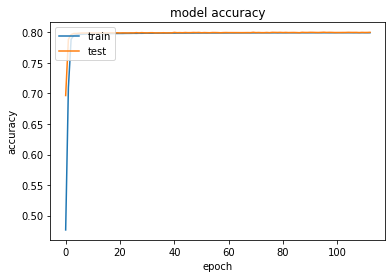

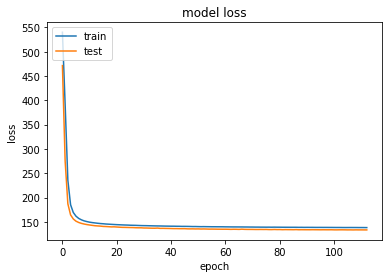

In [9]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

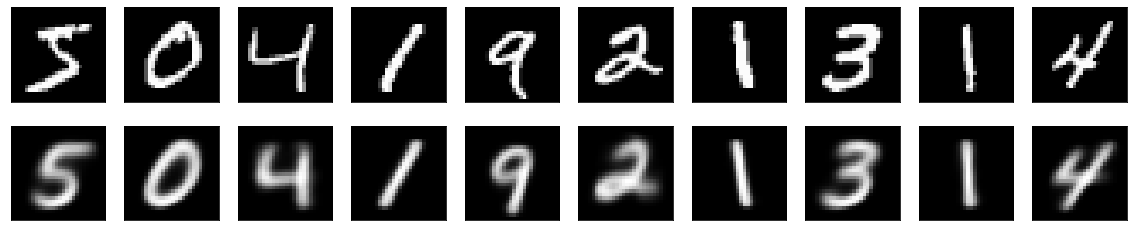

In [10]:
# проверим, как модель восстанавливает изобр-е

n = 10
imgs = x_train[:n]

cvae_gen_imgs = cv_autoencoder.predict([imgs, y_train_cat[:n]], batch_size=n)

plot_digits(imgs, cvae_gen_imgs)

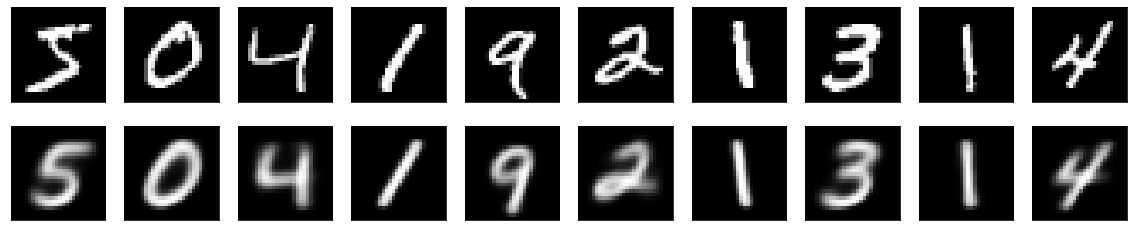

In [11]:
# по-другому проверим, как модель восстанавливает изобр-е и получим латентный слой

n = 10
imgs = x_train[:n]

encoded_imgs = cv_encoder.predict([imgs, y_train_cat[:n]], batch_size=n)[2]
latent_space = encoded_imgs

decoded_imgs = cv_decoder.predict([encoded_imgs, y_train_cat[:n]], batch_size=n)

plot_digits(imgs, decoded_imgs)

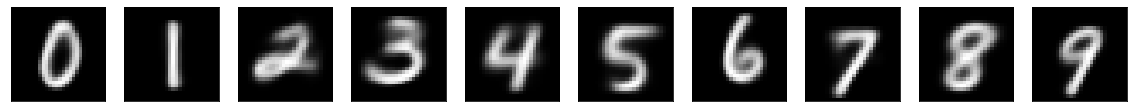

In [12]:
# сгенерируем n рандомных векторов размера latent_dim
# результат плох: пространство цифр очень небольшое, и мало случайных векторов оказываются в нём

n = 10
z = np.random.randn(n, latent_dim)
output = cv_decoder.predict([z, np.eye(n,10)])
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

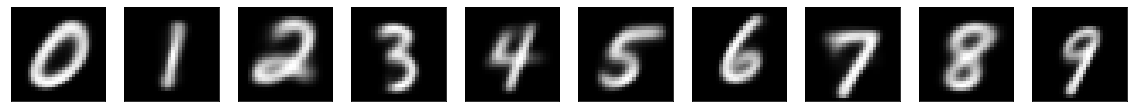

In [13]:
zz = np.array([np.random.normal(0, 1, latent_dim) for i in range(n)])

output = cv_decoder.predict([zz, np.eye(n,10)])
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [0]:
# получим latent_space со всего датасета

cvae_latent_space = cv_encoder.predict([x_train, y_train_cat])[2]

In [15]:
cvae_latent_space.shape, cvae_latent_space.mean(axis=0).shape, y_train.shape, np.unique(y_train)

((60000, 2),
 (2,),
 (60000,),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

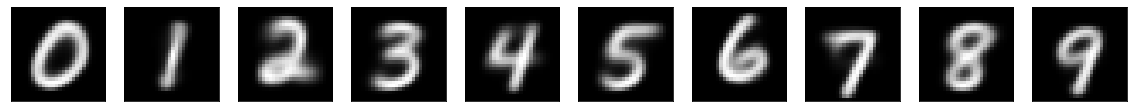

In [16]:
# сгенерируем 10 цифр из latent_space.mean(axis=0)

digits_from_latent = np.array([cvae_latent_space.mean(axis=0)]*10)
output = cv_decoder.predict([digits_from_latent, np.eye(10,10)])
plot_digits(output)

In [17]:
# прогоним векторы латентного пространтсва ч-з t-sne и 

from sklearn.manifold import TSNE

cvae_latent_embedded = TSNE(n_components=2).fit_transform(cvae_latent_space)

cvae_latent_embedded.shape

(60000, 2)

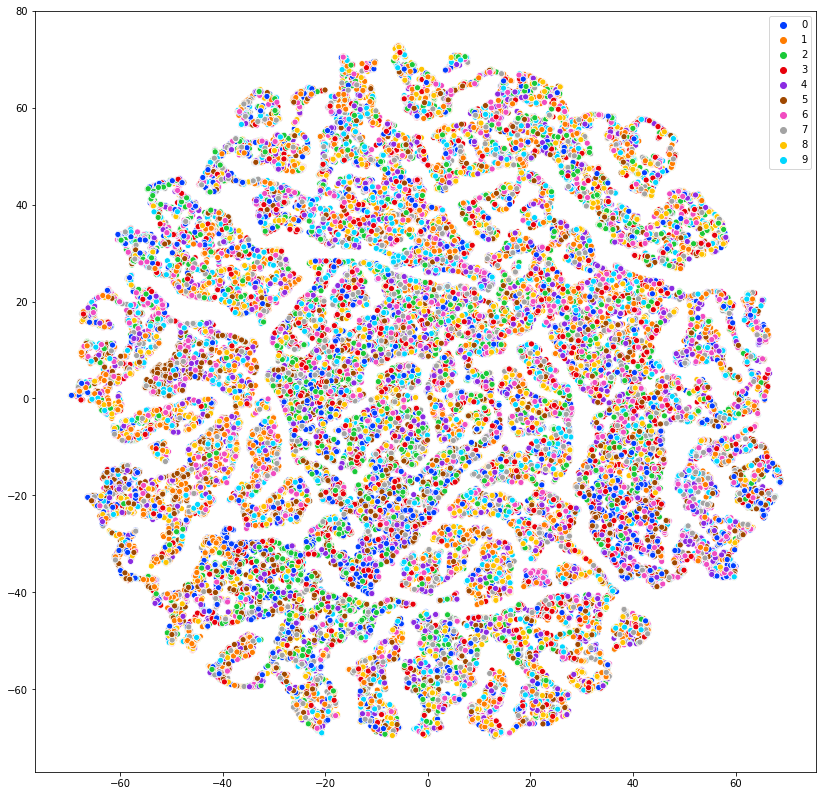

In [18]:
import seaborn as sns

plt.figure(figsize=(14, 14))
sns.scatterplot(x=cvae_latent_embedded[:, 1], y=cvae_latent_embedded[:, 0],
                hue=y_train, palette=sns.color_palette("bright", 10));

1. Структура расположения объектов после t-sne у CVAE получилась более однородная.
2. Loss на обучении выходит меньше, чем у variational autoencoder.
3. Качество восстановленных изображений лучше.
4. Восстановленные изображения не являются копиями кодируемых, т.к. берутся не из того же вектора латентного слоя, в который их закодировал энкодер, а из некого пространства, к которому относятся векторы латентного слоя сходных изображений.